In [1]:
import os
import yaml
import pickle
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import scipy.io
import pickle
from statistics import mean
# from plot import remove_repetitive_labels
from torch.utils.data import DataLoader, Dataset

from transformer.transformer_model import *
from transformations.transformations import *
from quaternion_metric import *


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Cuda available: ", torch.cuda.is_available())
# program seed and model seed
# seed = 321
# random.seed(seed)


# torch.manual_seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(seed)


def get_quaternion_difference_per_step(q1, q2):
    dq = []
    for i in range(q1.shape[0]):
        dq.append(norm_diff_quat(q1[i], q2[i]))
    return np.array(dq)


def get_position_difference_per_step(d1, d2):
    return np.linalg.norm(d1 - d2, axis=1)


def swap_dict_level(data):
    temp = {}
    for obj, value in data.items():
        for demo, traj in value.items():
            if not demo in temp:
                temp[demo] = {}
            temp[demo][obj] = traj
    return temp


def create_tags(objs):
    one_hots = torch.eye(len(objs))
    tag_dict = {}
    for i, obj in enumerate(objs):
        tag_dict[obj] = one_hots[i]
    return tag_dict


def to_obj_index(onehot):
    for i in range(onehot.shape[0]):
        if onehot[i] == 1:
            return i
    return 0


def find_task_by_index(demo_index, breaks):
    task_index = -1
    for br in breaks:
        if br > demo_index: break
        task_index += 1
    return task_index


def get_n_params(model):
    pp = 0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn * s
        pp += nn
    return pp


def create_chunks_of_indices(size, total, splits):
    offset = int(total / splits)
    all_indices = list(range(total))
    output = []
    for i in range(splits):
        holder = all_indices[offset * i:offset * i + size] + all_indices[:max(offset * i + size - total, 0)]
        output.append(sorted(holder))
    return output

def get_weights(df_traj, obj_pose_all):
    robot_pos = df_traj[['x', 'y', 'z']].to_numpy()
    dists = []
    for obj_pose in obj_pose_all:
        obj_pos = obj_pose[:3]
        dist_to_obj = np.linalg.norm(robot_pos -  obj_pos, axis = 1)
        dists.append(dist_to_obj)
    dists = np.array(dists)
    dists_min = np.min(dists, axis = 0)
    dists_min_normlized = dists_min / (np.max(dists_min))
    weights = 1/(dists_min_normlized)
    return weights
    
    
# Settings
ENABLE_TRANSFORMATION = True
TEST_ENCODER_LAYERS = False
USE_VIA_POINT = False
MODEL_PATH = "./models_v3/masked_models"  # read model from directory
TRAIN_LOG_DIR = './logs'  # saved trajectory directory (non-transformer models)
# saved trajectories from other models
SAVED_TRAJ_VER = "saved_traj_9-10-23"  # saved trajectory subdirectory (non-transformer models)
MODEL_COPIES = 1  # model copies for training different model on different unique demos

colors = ['red', 'blue', 'yellow', 'orange', 'green', 'purple', 'pink']
tasks = ["action_0", "action_1", "action_2"]
# tasks = ["action_1"]
raw_dir = './data/raw'
# raw_dir = './data/archive/raw'
processed_dir = raw_dir.replace('raw', 'processed')

task_dims = ['x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']
# task_dims = ['x', 'y', 'z']
n_dims = len(task_dims)
n_train = 15
n_tasks = len(tasks)
# model copy number, also determine which subset of demos to use
kth = 0

# =================
start_obj_index = [0, 0, 1]
# =================

# find all objects first
with open(os.path.join(raw_dir, 'task_config.yaml')) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
# all_objs = config["individuals"]
all_objs = ['bolt', 'nut', 'bin', 'jig']

# instaniate all object type and enable/disable via-points
unique_objs = ['trajectory'] + sorted(list(set(all_objs)))
if USE_VIA_POINT: unique_objs = ['trajectory', 'via-point'] + sorted(list(set(all_objs)))
if TEST_ENCODER_LAYERS: n_encoder_layers_set = [0, 1, 2, 3]
n_objs = len(unique_objs)

obj_tags = create_tags(unique_objs)  # tags created based on unique objects and added later on to object sequences
task_tags = create_tags(tasks)

train_objs_pose, train_traj_pose, train_weights = [], [], []
valid_objs_pose, valid_traj_pose, valid_weights = [], [], []
test_objs_pose, test_traj_pose, test_weights = [], [], []
train_traj_id = []

all_test_demos = []
test_splits = []
train_splits = []
saved_objects = {}
bad_demos_all_task = {'action_1': [],
            'action_0': [],
            'action_2': []}


# Load all task data and create data test/training splits
TrainDemos = {}
for i, task in enumerate(tasks):
    task_config_dir = os.path.join(processed_dir, task)
    task_root, demos, _ = next(os.walk(task_config_dir))
    bad_demos = bad_demos_all_task[task]

    demos = [demo for demo in demos if demo not in bad_demos]

    train_demos_pool = [demo for demo in random.sample(demos, 15)]
    test_valid_demos_pool_updated = [demo for demo in demos if demo not in train_demos_pool]

    # select unique training demo indices based on model copy number
    selected_indices = create_chunks_of_indices(n_train, len(train_demos_pool), MODEL_COPIES)[kth]
    train_demos = sorted([val for i, val in enumerate(train_demos_pool) if i in selected_indices])
    print(f"{task}-{all_objs}\nTraining Indices: {selected_indices}\nTraining Demos: {sorted(train_demos)}")
    # validation and test demo split
    TrainDemos[task] = train_demos
    split_size = int(len(test_valid_demos_pool_updated) / 2)
    valid_demos = random.sample(test_valid_demos_pool_updated, split_size)
    test_demos = [demo for demo in test_valid_demos_pool_updated if demo not in valid_demos]

    print(f'The number of training pool for task {task} is: {len(train_demos_pool)}')
    print(f'Training/Test Size/Validation Size: {len(train_demos)}/{len(test_demos)}/{len(valid_demos)}')
    
    test_splits.append(len(test_traj_pose))
    train_splits.append(len(train_traj_pose))
    for j, demo in enumerate(sorted(train_demos + valid_demos + test_demos)):
        traj_file = os.path.join(processed_dir, task, demo, demo + '.csv')
        df_traj = pd.read_csv(traj_file, index_col=0)[task_dims]

        traj_len = df_traj.shape[0]
        obj_buffer = obj_tags['trajectory'].repeat([traj_len, 1])
#         task_buffer = task_tags[task].repeat([traj_len, 1])
#         new_traj_data = np.concatenate([df_traj, obj_buffer, task_buffer], axis=1)
        new_traj_data = np.concatenate([df_traj, obj_buffer], axis=1)
        obj_pose_all = []
        obj_file = os.path.join(processed_dir, task, demo, demo + '_obj.csv')
        obj_wrist_file = os.path.join(processed_dir, task, demo, demo + '_obj_wrist.csv')
#         obj_file = os.path.join(processed_dir, task, demo, demo + '_obj_related.csv')
        try:
            df_obj = pd.read_csv(obj_file, index_col=0)
            df_obj_wrist = pd.read_csv(obj_wrist_file, index_col=0)
        except FileNotFoundError:
            continue
        for obj_ind in all_objs:
            if not obj_ind in df_obj.keys():
                individual_ind = obj_ind + '1'
                try:
                    obj_pose_zed = df_obj[individual_ind][task_dims].to_numpy()
                    obj_pose_wrist = df_obj_wrist[individual_ind][task_dims].to_numpy()
                except KeyError:  ## individual not seen in the scene
                    obj_pose_zed = np.zeros(n_dims)
                    obj_pose_zed[-1] = 1
            else:
                try:
                    obj_pose_zed = df_obj[obj_ind][task_dims].to_numpy()
                    obj_pose_wrist = df_obj_wrist[individual_ind][task_dims].to_numpy()
                except KeyError:  ## individual not seen in the scene
                    obj_pose_zed = np.zeros(n_dims)
                    obj_pose_zed[-1] = 1
            if n_dims == 3:
                obj_pose = np.concatenate([obj_pose, obj_tags[obj_ind], task_tags[task]])
                obj_pose = np.concatenate([obj_pose, obj_tags[obj_ind]])
            else:
                if not np.isnan(obj_pose_wrist).any():
                    obj_pose = obj_pose_wrist
                else:
                    obj_pose = obj_pose_zed
                obj_pose = np.concatenate([obj_pose, obj_tags[obj_ind]])
            obj_pose_all.append(obj_pose)
        weights = get_weights(df_traj, obj_pose_all)
#         plt.figure()
#         plt.plot(weights)
#         plt.show()

        if demo in train_demos:
            train_objs_pose.append(np.stack(obj_pose_all))
            train_traj_pose.append(new_traj_data)
            train_traj_id.append(demo)
            train_weights.append(weights)
        elif demo in test_demos:
            test_objs_pose.append(np.stack(obj_pose_all))
            test_traj_pose.append(new_traj_data)
            test_weights.append(weights)
        else:
            valid_objs_pose.append(np.stack(obj_pose_all))
            valid_traj_pose.append(new_traj_data)
            valid_weights.append(weights)
    print("test_demos:", test_demos)

C:\Users\xyao0\anaconda3\envs\dlc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cuda available:  False
action_0-['bolt', 'nut', 'bin', 'jig']
Training Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Training Demos: ['1709239995', '1709316664', '1709318726', '1709322779', '1709327194', '1709329298', '1709578142', '1709579404', '1709580277', '1709651247', '1709651801', '1709653211', '1709929042', '1709929566', '1709930093']
The number of training pool for task action_0 is: 15
Training/Test Size/Validation Size: 15/8/7
test_demos: ['1709240623', '1709244566', '1709245624', '1709315949', '1709320871', '1709581381', '1709582172', '1709652641']
action_1-['bolt', 'nut', 'bin', 'jig']
Training Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Training Demos: ['1709239995', '1709240623', '1709242793', '1709244566', '1709245081', '1709315949', '1709322779', '1709326577', '1709329298', '1709329992', '1709577586', '1709580277', '1709651801', '1709929042', '1709929566']
The number of training pool for task action_1 is: 15
Training/Test Size/Validation Siz

In [2]:
class TrajectoryDataset(Dataset):
    def __init__(self, obj_data, traj_data, transform_dims, weights, transform=[], 
                 max_seq_len= 170, return_index=False, train_traj_id = None):
        self.traj_data = traj_data
        self.obj_data = obj_data
        self.transform = transform
        self.dims = transform_dims
        self.max_seq_len = max_seq_len
        self.return_index = return_index
        self.train_traj_id = train_traj_id
        self.weights = weights

    def __getitem__(self, idx):
        traj_data = self.traj_data[idx].copy()
        obj_data = self.obj_data[idx].copy()
        weights = self.weights[idx].copy()
            
#         Transformation process
        for tf_func in self.transform:
            obj_data, traj_data = tf_func(obj_data, traj_data)
            
        # Pad trajectory sequence
        traj_data = torch.tensor(traj_data)
        obj_data = torch.tensor(obj_data)
        weights = torch.tensor(weights)
        if traj_data.shape[0] < self.max_seq_len:
            diff = self.max_seq_len - traj_data.shape[0]
            pad = torch.zeros([diff, traj_data.shape[1]])
            pad_weights = torch.zeros(diff)
            traj_data = torch.cat([traj_data, pad])
            weights = torch.cat([weights, pad_weights])

        traj_hidden = traj_data.clone()
        traj_hidden[:, :self.dims] = 0
        if self.return_index:
            return obj_data, traj_data, traj_hidden, weights, idx
        return obj_data, traj_data, traj_hidden, weights

    def __len__(self):
        return len(self.obj_data)


def normalize_wrapper(average, std):
    """normalize for multiprocessing"""
    return lambda x: normalize_3d(x, average, std)


def normalize_3d(entry, average, std):
    entry[:, :3] = (entry[:, :3] - average) / std
    return entry


def get_obj_tag(entry):
    tag_seq = entry[n_dims:n_dims + n_objs]
    return (tag_seq == 1).nonzero(as_tuple=True)[0]


# Find training mean and std
contiguous_traj = np.concatenate(train_traj_pose)
train_mean = np.mean(contiguous_traj[:, :3], axis=0)
train_std = np.std(contiguous_traj[:, :3]) / 3

# Normalization
norm_func = normalize_wrapper(train_mean, train_std)
train_objs_pose = list(map(norm_func, train_objs_pose))
train_traj_pose = list(map(norm_func, train_traj_pose))
valid_objs_pose = list(map(norm_func, valid_objs_pose))
valid_traj_pose = list(map(norm_func, valid_traj_pose))
test_objs_pose = list(map(norm_func, test_objs_pose))
test_traj_pose = list(map(norm_func, test_traj_pose))


# Infer info from data 

action_0 8
action_1 8
action_2 8


<IPython.core.display.Javascript object>


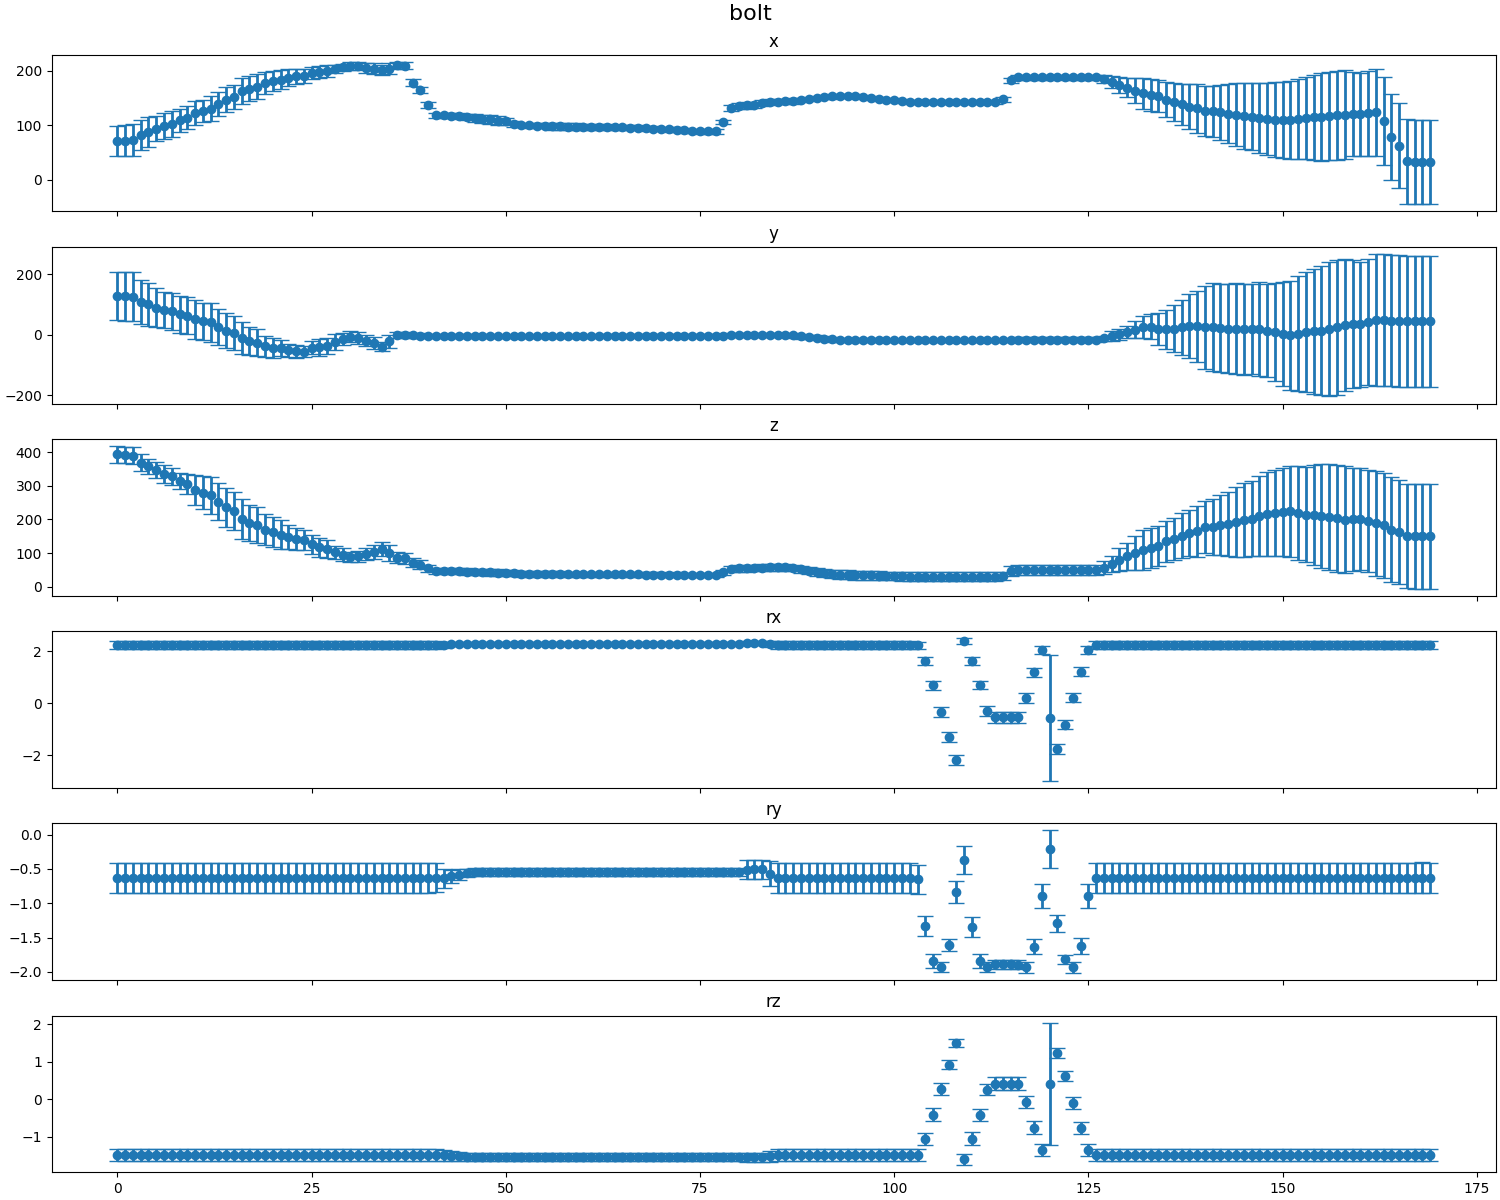

<IPython.core.display.Javascript object>


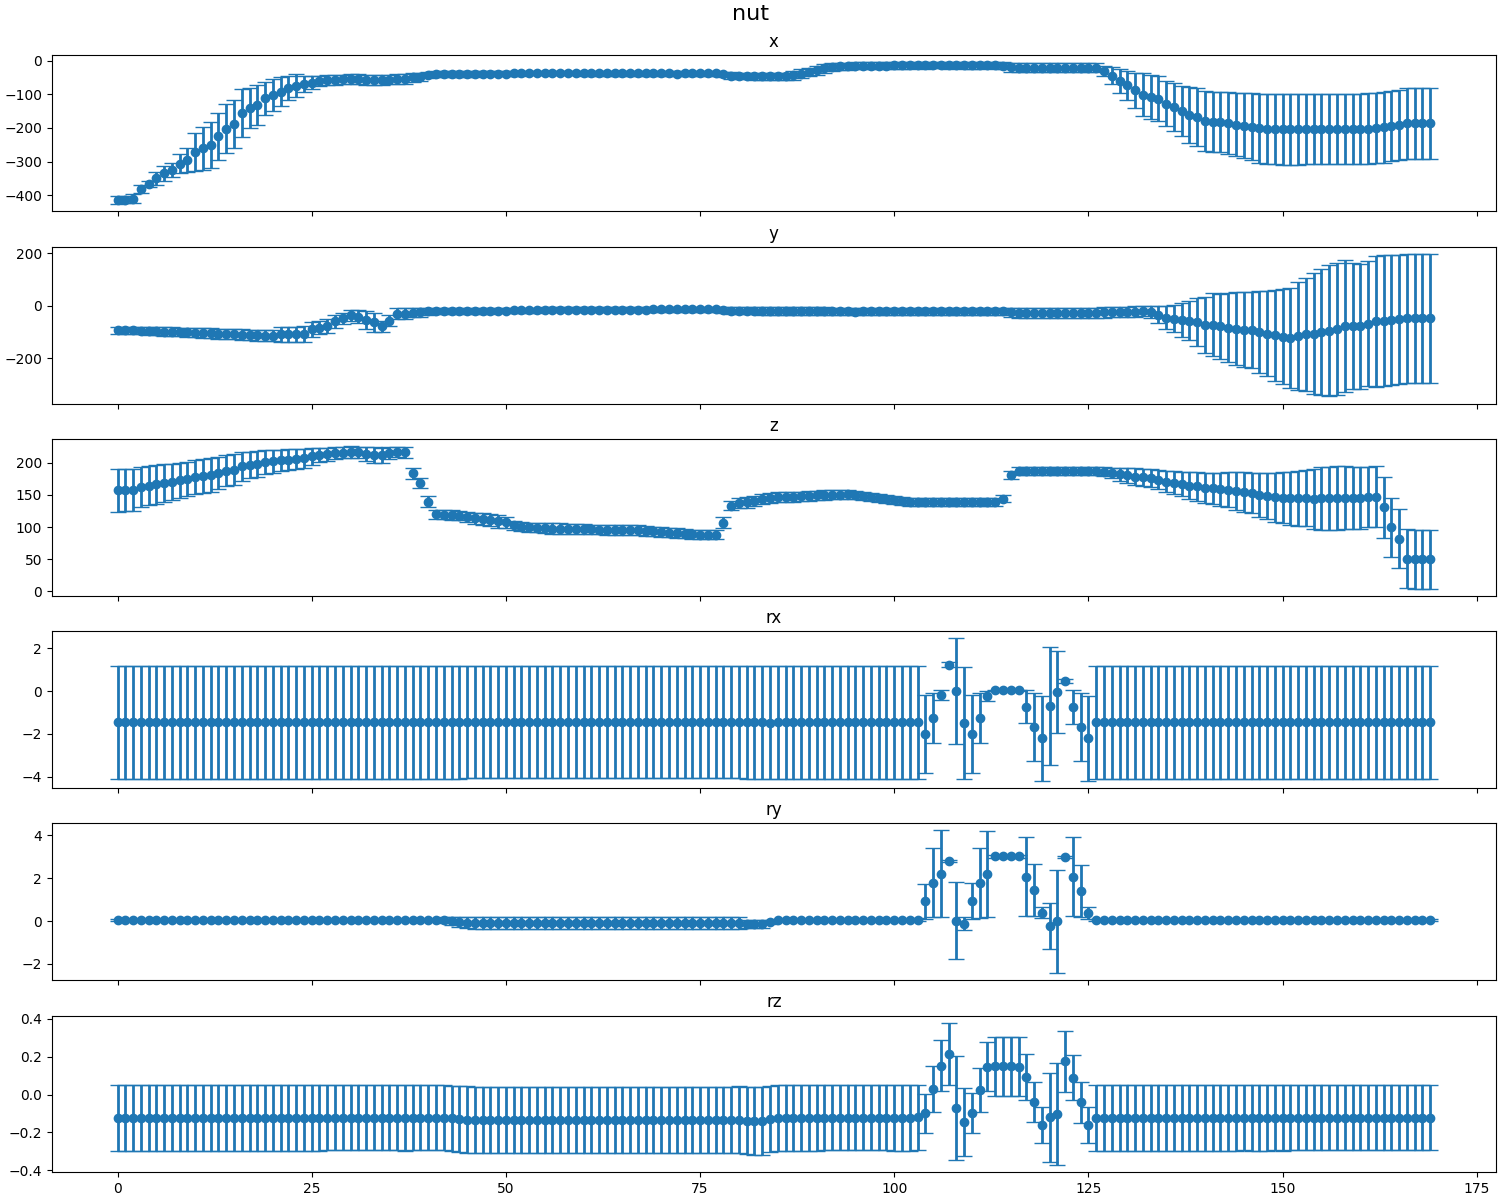

<IPython.core.display.Javascript object>


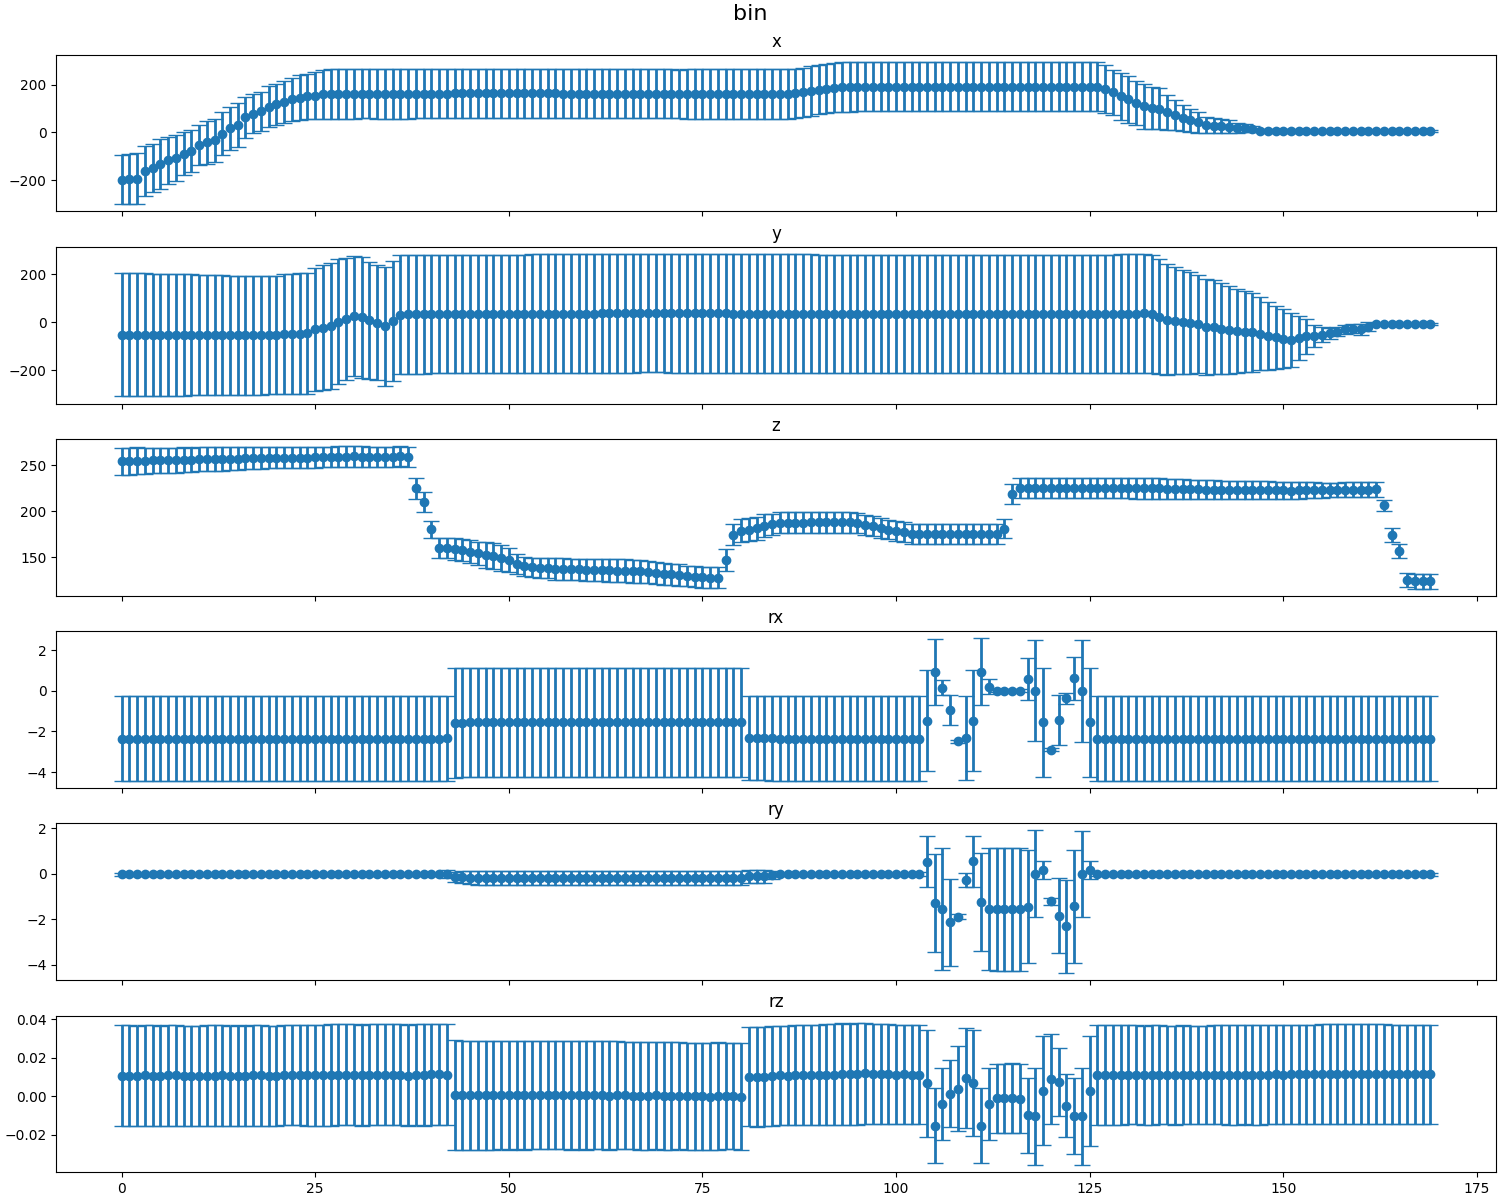

<IPython.core.display.Javascript object>


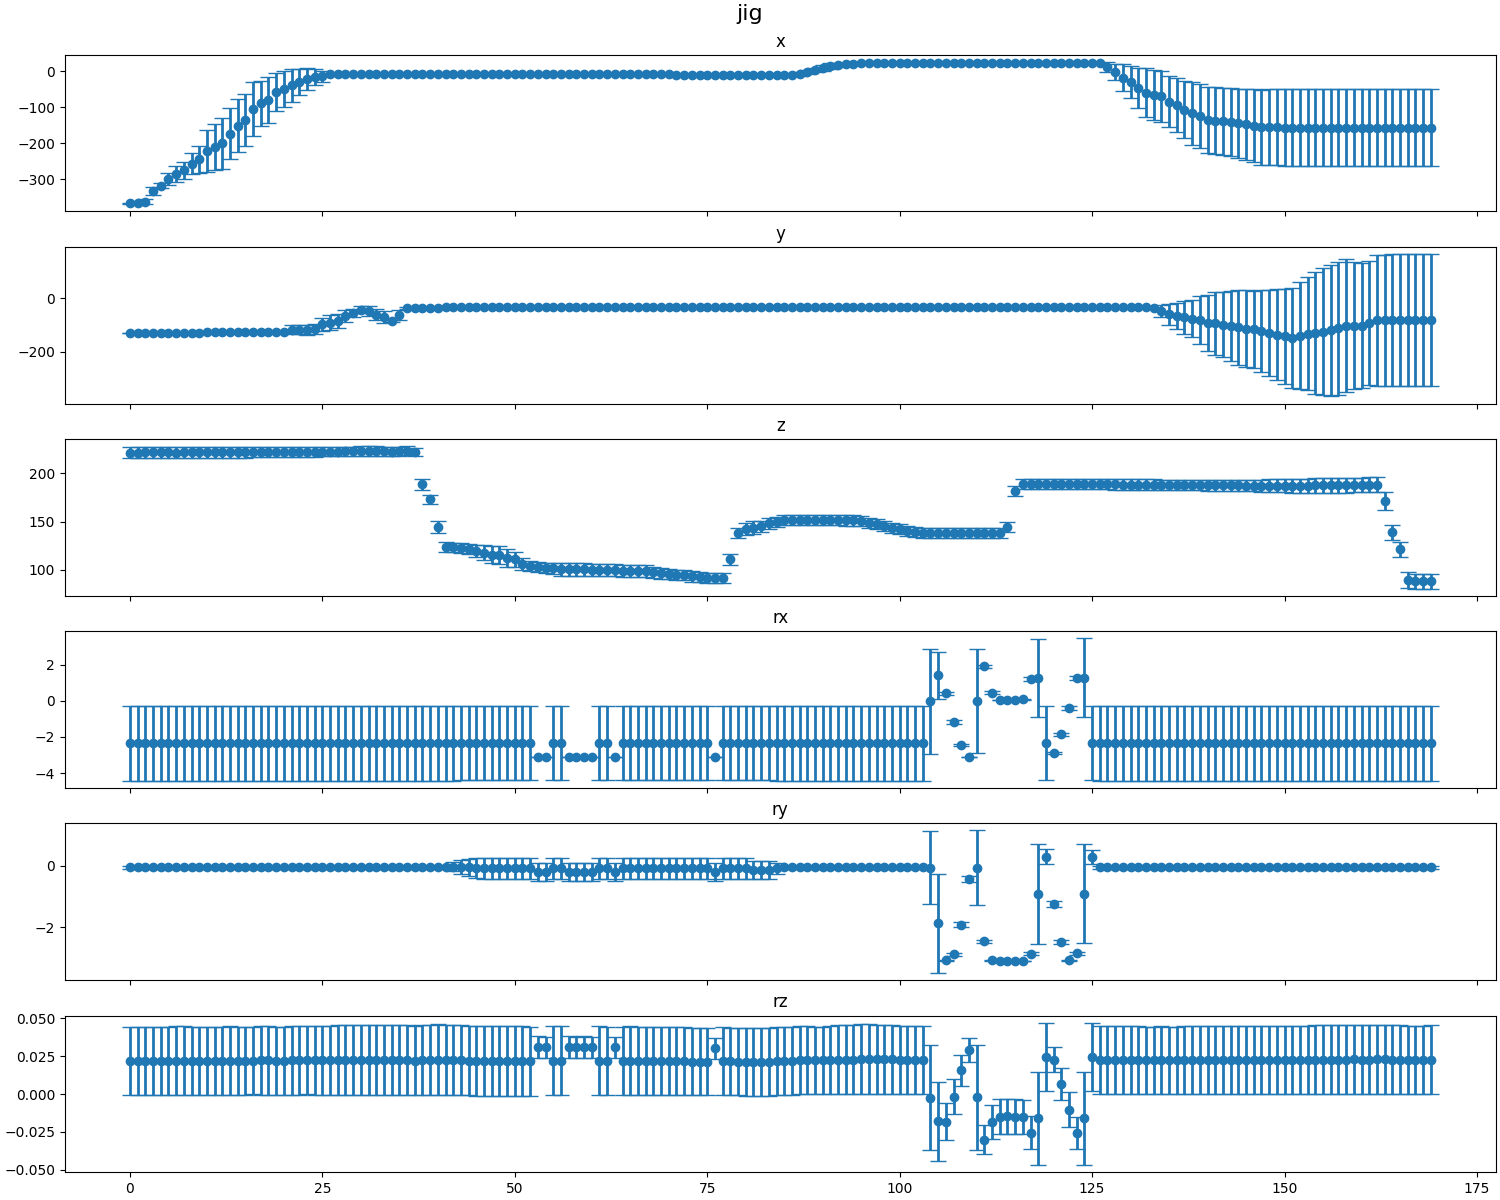

In [46]:
%matplotlib notebook
from process_data import normalize, denormalize
plot_action = 'action_2'

oris = ['euler', 'rotvec', 'quat']
ori = oris[1]
if ori == 'euler':
    plot_dims = ['x', 'y', 'z', '$\\alpha$', '$\\beta$', '$\\gamma$']
elif ori == 'rotvec':
    plot_dims = ['x', 'y', 'z', 'rx', 'ry', 'rz']
elif  ori == 'quat':
    plot_dims = ['x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']


var_all_actions = {}
for action in tasks:
#     demos = os.listdir(os.path.join(processed_dir, action))
    demos = sorted(os.listdir(os.path.join(processed_dir, action)))[:10]
    demos = [d for d in demos if d not in ['1709242793', '1709244566']]
    print(action, len(demos))
    trajs_ = []
    local_trajs = {obj: [] for obj in all_objs}
    for demo in demos:
        traj_file = os.path.join(processed_dir, action, demo, f'{demo}.csv')
        df = pd.read_csv(traj_file)
        traj = df[task_dims].to_numpy()
        for obj in all_objs:
            obj_pose_combined = os.path.join(processed_dir, action, demo, f'{demo}_obj_combined.csv')
            try:
                df_pose = pd.read_csv(obj_pose_combined, index_col=0)
            except FileNotFoundError:
                continue
            unique_obj = [tmp for tmp in df_pose.keys() if obj in tmp][0]
            obj_pose = df_pose.loc[task_dims, unique_obj].to_numpy()
            rotmat = R.from_quat(obj_pose[3:]).as_matrix()
            H_obj_in_global = homogeneous_transform(rotmat, obj_pose[:3])
            H_global_in_obj = inverse_homogeneous_transform(H_obj_in_global)

            traj_obj = lintrans(traj, H_global_in_obj)
            if ori == 'euler':
                traj_obj_euler = traj_obj.copy()[:,:-1]
                traj_obj_euler[:, 3:] = R.from_quat(traj_obj[:, 3:]).as_euler('xyz', degrees=True)
                local_trajs[obj].append(traj_obj_euler)
            elif ori == 'rotvec':
                traj_obj_rotvec = traj_obj.copy()[:, :-1]
                traj_obj_rotvec[:, 3:] = R.from_quat(traj_obj[:, 3:]).as_rotvec()
                local_trajs[obj].append(traj_obj_rotvec)
            else:
                local_trajs[obj].append(traj_obj)

#     for obj in all_objs:
#         pos_all = np.array(local_trajs[obj])
#         fig = plt.figure(figsize=(9, 5))
#         ax = fig.add_subplot(1, 1, 1, projection='3d')
#         for pos in pos_all:
#             dist = np.linalg.norm(pos[:, :3], axis=1)
#             ind = np.argmin(dist)
#             line = ax.plot(pos[:, 0], pos[:, 1], pos[:, 2],
#                            color='blue', label=f'traj')
#             ax.plot(pos[0, 0], pos[ 0, 1], pos[0, 2], 'o',
#                     color='blue')
#             ax.plot(pos[ind, 0], pos[ind, 1], pos[ind, 2], 's',
#                     color='red', )
#         ax.set_title(obj)
#         plt.show()
        
    var = {}
    for obj in all_objs:
        local_traj = np.array(local_trajs[obj])
#         local_traj[:,:,:3], maxes, mins = normalize(local_traj[:, :, :3])
        var[obj] = np.var(local_traj, axis = 0) 
        mean = np.mean(local_traj, axis = 0)
        std = np.std(local_traj, axis = 0)
        if action == plot_action:
            fig, axes = plt.subplots(len(plot_dims), 1, sharex=True, constrained_layout=True)
            fig.set_figheight(12)
            fig.set_figwidth(15)
            for i, ax in enumerate(axes):
                ax.errorbar(np.arange(local_traj.shape[1]), mean[:, i], std[:, i], fmt='o', linewidth=2, capsize=6)
                ax.set_title(plot_dims[i])
                if i>2 and ori == 'quat':
                    ax.set_ylim(-1.1, 1.1)
            fig.suptitle(obj, fontsize=16)
    var_all_actions[action] = var
    

In [56]:
ind = 60
d = 1
obj1 = 'bolt'
obj2 = 'jig'
print(var_all_actions[plot_action][obj1][ind, d])
print(var_all_actions[plot_action][obj2][ind, d])

23.096901754280985
1.949374943952022


In [4]:
from transformations import homogeneous_transform, lintrans, lintrans_cov
from scipy.stats import multivariate_normal as mvn
from scipy.spatial.transform import Rotation as R
from quaternion_metric import *

def get_dist_traj_to_obj(traj_pos, obj_pos):
    
    dist_to_obj = np.linalg.norm(traj_pos -  obj_pos, axis = 1)
    return dist_to_obj

def get_gaussians_per_step(traj_pose, covs):
    mus, sigmas = [], []
    D = traj_pose.shape[1]
    for i, p in enumerate(traj_pose):
        mu = p
        sigma = np.eye(D) * covs[i]
        mus.append(mu)
        sigmas.append(sigma)
    return mus, sigmas

def get_gaussians_per_obj(obj_pos, sigma = 0.8):
    dists = []
    for i in range(obj_pos.shape[0]):
        dist = mvn(obj_pos[i], np.eye(obj_pos.shape[1]) * sigma)
        dists.append(dist)
    return dists

def get_gaussians_per_obj_new(obj_pos, sigmas):
    dists = []
    for i in range(obj_pos.shape[0]):
        dist = mvn(obj_pos[i], np.eye(obj_pos.shape[1]) * sigmas[i])
        dists.append(dist)
    return dists

def get_likelihood_per_step(traj, distributions):
    lls = np.zeros((len(distributions), traj.shape[0]))
    for i, dist in enumerate(distributions):
        lls[i] = dist.pdf(traj)
    likelihoods = lls / np.sum(lls, axis = 0)
    return likelihoods
        

def get_mean_cov_hats(ref_means, ref_covs, min_len=None):
    ref_pts = len(ref_means)
    
    if min_len is None:
        min_len = min(len(r) for r in ref_means)

    # Precompute inverses of covariance matrices
    inv_covs = np.linalg.inv(np.array(ref_covs))

    mean_hats = np.empty((min_len, *ref_means[0][0].shape))
    sigma_hats = np.empty((min_len, *ref_covs[0][0].shape))

    for p in range(min_len):
        inv_sum = np.sum(inv_covs[:, p, :, :], axis=0)
        sigma_hat = np.linalg.inv(inv_sum)
        sigma_hats[p] = sigma_hat

        mean_w_sum = np.zeros(ref_means[0][0].shape)
        for ref in range(ref_pts):
            mean_w_sum += np.dot(inv_covs[ref][p], ref_means[ref][p])
        mean_hats[p] = np.dot(sigma_hat, mean_w_sum)
    return mean_hats, sigma_hats

def augment(traj_data, obj_pose_data, inds, methods, xrange = [-1, 1], yrange = [-1, 1], degrees = [-30, 30], axis='z', sigma = 0.5):
    
    traj = traj_data.copy()
    obj_pose = obj_pose_data.copy()
    
    mus_all, sigmas_all = [], []
    obj_pos = obj_pose[:, :3]
    ### Take the start and end point of the trajectory as objects
    obj_pos = np.r_[obj_pos, traj[0, :3].reshape(-1, 3)]
#     obj_pos = np.r_[obj_pos, traj[-1, :3].reshape(-1, 3)]
    obj_pos_tmp = obj_pos[:, :3]

    distributions = get_gaussians_per_obj(obj_pos_tmp, sigma = sigma)
    likelihoods = get_likelihood_per_step(traj[:, :3], distributions)
    labels = np.argmax(likelihoods, axis= 0)
    # related_inds = [1, 3, 4, 5]
    for i in range(obj_pos.shape[0]): ### the ith object
        covs = 1 / likelihoods[i,:]

        mus_obj, sigmas_obj = get_gaussians_per_step(traj[:,:7], covs)
        mus_obj, sigmas_obj = np.array(mus_obj), np.array(sigmas_obj)

        if i in inds:
            ind = inds.index(i)
            if methods[ind] == 'translation_only':
                degree = 0
                x_trans = random.uniform(xrange[0], xrange[1])
                y_trans = random.uniform(yrange[0], yrange[1])
                translation = np.array([x_trans, y_trans, 0])
            elif methods[ind] == 'rotation_only':
                degree = random.randrange(degrees[0], degrees[1])
                degree = 50
                translation = np.array([0, 0, 0])
            elif methods[ind] == 'translation_and_rotation':
                x_trans = random.uniform(xrange[0], xrange[1])
                y_trans = random.uniform(yrange[0], yrange[1])
                translation = np.array([x_trans, y_trans, 0])
                degree = random.randrange(degrees[0], degrees[1])   
            print(degree, 'aaaaaa')
            
            rotmatrix = R.from_euler(axis, degree, degrees=True).as_matrix()
            H = homogeneous_transform(rotmatrix, translation)
            pt_obj = obj_pos[i].copy()       
            pt_traj_ind = np.argmin(get_dist_traj_to_obj(traj[:, :3], obj_pos[i]))
            pt_traj = traj[pt_traj_ind,:3]
            
            mus_obj[:, :3] = mus_obj[:, :3] - pt_traj
            mus_obj[:, :7] = lintrans(mus_obj[:, :7], H)
            mus_obj[:, :3] = mus_obj[:, :3] + pt_traj
            
            obj_pose[i, :3] = obj_pose[i, :3] - pt_obj
            obj_pose[i, :7] = lintrans(obj_pose[i, :7].reshape(1, -1), H)
            obj_pose[i, :3] = obj_pose[i, :3] + pt_obj

            sigmas_obj = lintrans_cov(np.array(sigmas_obj), H)
    
        mus_all.append(mus_obj)
        sigmas_all.append(sigmas_obj)
    
    mu_mean, sigma_mean = get_mean_cov_hats(mus_all, sigmas_all)
    traj[:, :7] = mu_mean
    return traj, obj_pose, labels

def augment2(traj_data, obj_pose_data, transform, xrange = [-1, 1], yrange = [-1, 1], degrees = [-30, 30], axis='z'):
    
    traj = traj_data.copy()
    obj_pose = obj_pose_data.copy()
    do_translation = transform.do_translation
    do_rotation = transform.do_rotation
    modify_traj_pos = transform.modify_traj_pos
    modify_traj_ori = transform.modify_traj_ori
    transform_sigmas = transform.sigmas
    
    mus_all, sigmas_all = [], []
    obj_pos = obj_pose[:, :2]
    ### Take the start and end point of the trajectory as objects
    obj_pos = np.r_[obj_pos, traj[0, :2].reshape(-1, 3)]
    do_translation.append(False)
    do_rotation.append(False)
    modify_traj_pos.append(False)
    modify_traj_ori.append(False)
    transform_sigmas.append(0.1)

#     obj_pos = np.r_[obj_pos, traj[-1, :3].reshape(-1, 3)]
    obj_pos_tmp = obj_pos[:, :3]

    distributions = get_gaussians_per_obj_new(obj_pos_tmp, sigmas = transform_sigmas)
    likelihoods = get_likelihood_per_step(traj[:, :3], distributions)
    labels = np.argmax(likelihoods, axis= 0)
    
    
    # related_inds = [1, 3, 4, 5]
    for i in range(obj_pos.shape[0]):
        covs = 1 / likelihoods[i,:]

        mus_obj, sigmas_obj = get_gaussians_per_step(traj[:,:7], covs)
        mus_obj, sigmas_obj = np.array(mus_obj), np.array(sigmas_obj)
                
        if (do_translation[i] or do_rotation[i]): ### Rotate and/or traslate object
            translation = np.zeros(3)
            degree = 0
            if do_translation:
                x_trans = random.uniform(xrange[0], xrange[1])
                y_trans = random.uniform(yrange[0], yrange[1])
                translation = np.array([x_trans, y_trans, 0])
            if do_rotation:
                degree = random.randrange(degrees[0], degrees[1])
            rotmatrix = R.from_euler(axis, degree, degrees=True).as_matrix()
            H = homogeneous_transform(rotmatrix, translation) ### Homogeneous transformation matrix
            
            ### Transform object
            pt_obj = obj_pos[i].copy()   
            obj_pose[i, :3] = obj_pose[i, :3] - pt_obj
            obj_pose[i, :7] = lintrans(obj_pose[i, :7].reshape(1, -1), H)
            obj_pose[i, :3] = obj_pose[i, :3] + pt_obj
            
            ### Transform the whole trajectory about the closest trjectory point to the ith object
            if (modify_traj_pos or modify_traj_ori):
                pt_traj_ind = np.argmin(get_dist_traj_to_obj(traj[:, :3], obj_pos[i]))
                pt_traj = traj[pt_traj_ind,:3].copy()
                
                mus_obj_new = mus_obj.copy()
                mus_obj_new[:, :3] = mus_obj_new[:, :3] - pt_traj
                mus_obj_new[:, :7] = lintrans(mus_obj_new[:, :7], H)
                mus_obj_new[:, :3] = mus_obj_new[:, :3] + pt_traj
                if modify_traj_pos[i]:
                    mus_obj[:,:3] = mus_obj_new[:, :3]
                if modify_traj_ori[i]:
                    mus_obj[:,3:] = mus_obj_new[:, 3:]
                sigmas_obj = lintrans_cov(np.array(sigmas_obj), H)
        mus_all.append(mus_obj)
        sigmas_all.append(sigmas_obj)
    
    mu_mean, sigma_mean = get_mean_cov_hats(mus_all, sigmas_all)
    traj[:, :7] = mu_mean
    return traj, obj_pose, labels

def winer_takes_all(mus_all, labels):
    result = np.zeros((mus_all[0].shape[0], mus_all[0].shape[1]))
    for i in range(mus_all[0].shape[0]):
        result[i, :] = mus_all[labels[i]][i, :]
    return result
        

def augment3(traj_data, obj_pose_data, transforms, sigmas):
    
    traj = traj_data.copy()
    obj_poses = obj_pose_data.copy()
    
    mus_all, sigmas_all = [], []
    gaussian_dim = 3
    obj_pos = obj_poses[:, :gaussian_dim]
    ### Take the start and end point of the trajectory as objects
    obj_pos = np.r_[obj_pos, traj[0, :gaussian_dim].reshape(-1, gaussian_dim)]
    sigmas.append(sigmas[0])

#     obj_pos = np.r_[obj_pos, traj[-1, :3].reshape(-1, 3)]
    obj_pos_tmp = obj_pos[:, :gaussian_dim]

    distributions = get_gaussians_per_obj_new(obj_pos_tmp, sigmas = sigmas)
    likelihoods = get_likelihood_per_step(traj[:, :gaussian_dim], distributions)
    labels = np.argmax(likelihoods, axis= 0)
    
    
    for i in range(obj_pos.shape[0]):
        covs = 1 / likelihoods[i,:]
        mus_obj, sigmas_obj = get_gaussians_per_step(traj[:,:7], covs)
        mus_obj, sigmas_obj = np.array(mus_obj), np.array(sigmas_obj)
        if i < len(obj_poses): ### all the real objects excluding the start point 
            obj_pose = obj_poses[i]
            transforms_obj = transforms[i]
            for trans in transforms_obj:
                obj_pose, mus_obj, sigmas_obj = trans.transform(obj_pose, mus_obj, sigmas_obj)
                obj_poses[i] = obj_pose
        mus_all.append(mus_obj)
        sigmas_all.append(np.array(sigmas_obj))
        
#     mu_mean, sigma_mean = get_mean_cov_hats(mus_all, sigmas_all)
    mu_mean = winer_takes_all(mus_all, labels)
    traj[:, :7] = mu_mean
    return traj, obj_poses, labels
    

def augment4(traj_data, obj_pose_data, transforms, variance):
    traj = traj_data.copy()
    obj_poses = obj_pose_data.copy()
    mus_all, sigmas_all = [], []    
    
    variance_sum = np.mean(variance[:, :, :3], axis = 2)
#     ind = 60
#     print(variance_sum.shape)
#     print(variance[0, ind, :3], variance_sum[0, ind])
#     print(variance[1, ind, :3],variance_sum[1, ind])
#     print(variance[2, ind, :3],variance_sum[2, ind])
#     print(variance[3, ind, :3],variance_sum[3, ind])
#     raise
    labels = np.argmin(variance_sum, axis = 0 )
    print(labels)
    for i in range(obj_poses.shape[0]):
        mus_obj, sigmas_obj = get_gaussians_per_step(traj[:,:7], variance[i])
        mus_obj, sigmas_obj = np.array(mus_obj), np.array(sigmas_obj)
        if i < len(obj_poses): ### all the real objects excluding the start point 
            obj_pose = obj_poses[i]
            transforms_obj = transforms[i]
            for trans in transforms_obj:
                obj_pose, mus_obj, sigmas_obj = trans.transform(obj_pose, mus_obj, sigmas_obj)
                obj_poses[i] = obj_pose
        mus_all.append(mus_obj)
        sigmas_all.append(np.array(sigmas_obj))
        
    mu_mean, sigma_mean = get_mean_cov_hats(mus_all, sigmas_all)
#     mu_mean = winer_takes_all(mus_all, labels)
    traj[:, :7] = mu_mean
    return traj, obj_poses, labels


This is action_1
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3]
50
50


<IPython.core.display.Javascript object>


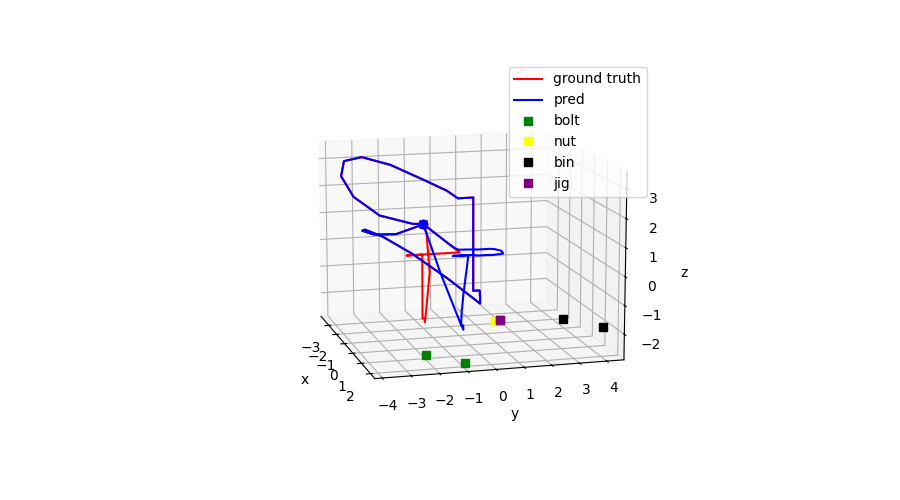

<IPython.core.display.Javascript object>


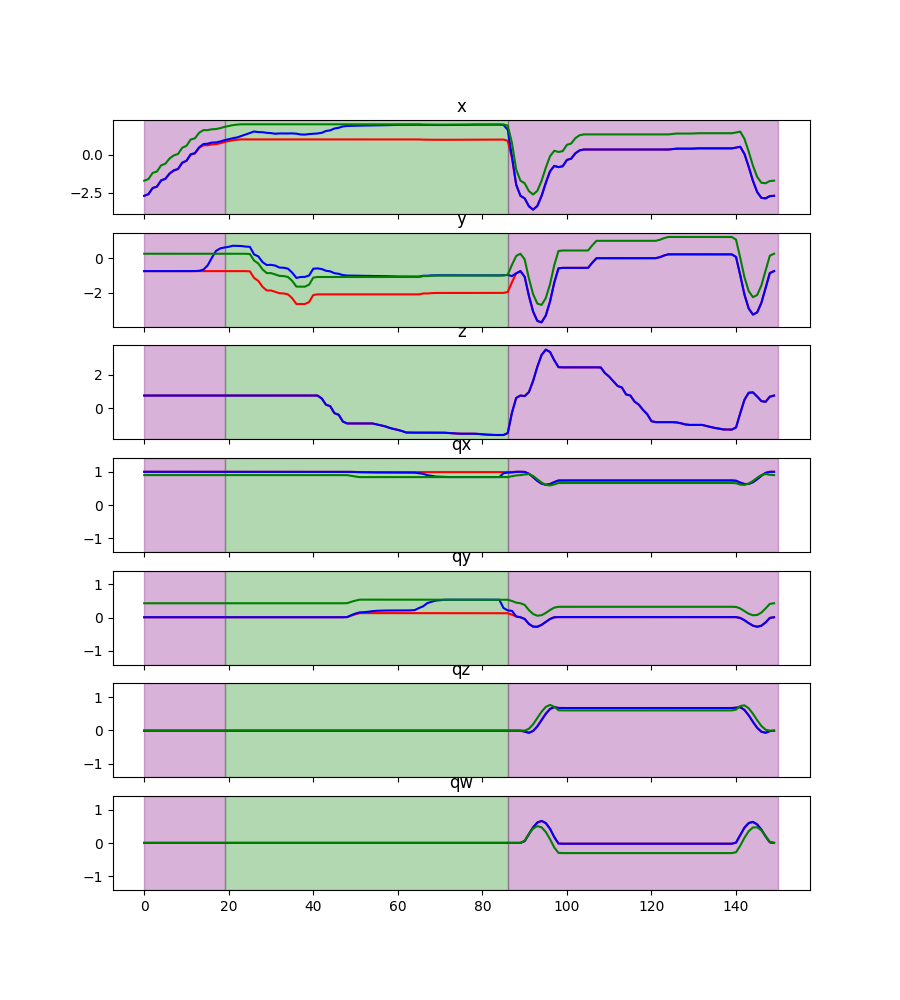

In [26]:
class Transform():
    def __init__(self, do_translation, do_rotation, modify_traj_pos, modify_traj_ori, sigmas):
        self.do_translation = do_translation
        self.do_rotation = do_rotation
        self.modify_traj_pos = modify_traj_pos
        self.modify_traj_ori = modify_traj_ori
        self.sigmas = sigmas
        
class Rotation():
    def __init__(self, modify_traj_pos = False, modify_traj_ori = True):
        self.modify_traj_pos = modify_traj_pos
        self.modify_traj_ori = modify_traj_ori
        
    def transform(self, obj_pose, mus_obj, sigmas_obj, degrees = [-30, 30], axis='z'):
        degree = random.randrange(degrees[0], degrees[1])
        degree = 50
        print(degree)
        rotmatrix = R.from_euler(axis, degree, degrees=True).as_matrix()
        translation = np.zeros(3)
        H = homogeneous_transform(rotmatrix, translation) ### Homogeneous transformation matrix
        
        ### Transform object
        pt_obj = obj_pose[:3].copy()   
        obj_pose[:3] = obj_pose[:3] - pt_obj
        obj_pose[:7] = lintrans(obj_pose[:7].reshape(1, -1), H)
        obj_pose[:3] = obj_pose[:3] + pt_obj
        
    ### Transform the whole trajectory about the closest trjectory point to the ith object
        if (self.modify_traj_pos or self.modify_traj_ori):
            pt_traj_ind = np.argmin(get_dist_traj_to_obj(mus_obj[:, :3], obj_pose[:3]))
            pt_traj = mus_obj[pt_traj_ind,:3].copy()

            mus_obj_new = mus_obj.copy()
            mus_obj_new[:, :3] = mus_obj_new[:, :3] - pt_traj
            mus_obj_new[:, :7] = lintrans(mus_obj_new[:, :7], H)
            mus_obj_new[:, :3] = mus_obj_new[:, :3] + pt_traj
            if self.modify_traj_pos:
                mus_obj[:,:3] = mus_obj_new[:, :3]
            if self.modify_traj_ori:
                mus_obj[:,3:] = mus_obj_new[:, 3:]
            sigmas_obj = lintrans_cov(np.array(sigmas_obj), H)
        return obj_pose, mus_obj, sigmas_obj

class Translation():
    def __init__(self, modify_traj_pos = False):
        self.modify_traj_pos = modify_traj_pos
        
    def transform(self, obj_pose, mus_obj, sigmas_obj, xrange = [-1, 1], yrange = [-1, 1]):
        x_trans = random.uniform(xrange[0], xrange[1])
        y_trans = random.uniform(yrange[0], yrange[1])
        x_trans = 1
        y_trans = 1
        translation = np.array([x_trans, y_trans, 0])
        rotmatrix = np.eye(3)
        H = homogeneous_transform(rotmatrix, translation) ### Homogeneous transformation matrix
        
        ### Transform object
        pt_obj = obj_pose[:3].copy()   
        obj_pose[:3] = obj_pose[:3] - pt_obj
        obj_pose[:7] = lintrans(obj_pose[:7].reshape(1, -1), H)
        obj_pose[:3] = obj_pose[:3] + pt_obj
        
    ### Transform the whole trajectory about the closest trjectory point to the ith object
        if self.modify_traj_pos:
            pt_traj_ind = np.argmin(get_dist_traj_to_obj(mus_obj[:, :3], obj_pose[:3]))
            pt_traj = mus_obj[pt_traj_ind,:3].copy()

            mus_obj_new = mus_obj.copy()
            mus_obj_new[:, :3] = mus_obj_new[:, :3] - pt_traj
            mus_obj_new[:, :7] = lintrans(mus_obj_new[:, :7], H)
            mus_obj_new[:, :3] = mus_obj_new[:, :3] + pt_traj
            mus_obj[:,:3] = mus_obj_new[:, :3]
            sigmas_obj = lintrans_cov(np.array(sigmas_obj), H)
        return obj_pose, mus_obj, sigmas_obj

%matplotlib notebook
from matplotlib import pyplot as plt
# from plot_quaternion import plot_quaterinon

train_ind = 21
task_idx = find_task_by_index(train_ind, train_splits)
print(f'This is action_{task_idx}')
sigma = 0.1
traj_data = train_traj_pose[train_ind]
obj_pose_data = train_objs_pose[train_ind]

# inds = [0]
# methods = ['rotation_only']

inds = [1]
methods = ['translation_and_rotation']

inds = [0, 2]
methods = ['rotation_only', 'rotation_only']

transforms_all_action = {0:[[Rotation(modify_traj_pos = False, modify_traj_ori = False), Translation(modify_traj_pos = False)],
                           [Rotation(modify_traj_pos = False, modify_traj_ori = True), Translation(modify_traj_pos = True)],
                           [Rotation(modify_traj_pos = False, modify_traj_ori = False), Translation(modify_traj_pos = False)],
                           []],
                         1:[[Rotation(modify_traj_pos = False, modify_traj_ori = True),Translation(modify_traj_pos = True)],
                           [],
                           [Rotation(modify_traj_pos = False, modify_traj_ori = False), Translation(modify_traj_pos = False)],
                           []],
                        2:[[Rotation(modify_traj_pos = False, modify_traj_ori = True)],
                           [],
                           [Rotation(modify_traj_pos = False, modify_traj_ori = False), Translation(modify_traj_pos = True)],
                           []
                           ]}

v = []
for obj in all_objs:
    v.append(var_all_actions[f'action_{task_idx}'][obj])
v = np.array(v) ** 2

# traj, obj_pose, labels = augment3(traj_data, obj_pose_data, transforms_all_action[task_idx], sigmas = [sigma] * 4)
traj, obj_pose, labels = augment4(traj_data, obj_pose_data, transforms_all_action[task_idx], v)
# traj, obj_pose, labels = augment(traj_data, obj_pose_data, inds, methods)
                         
plot_arrows = False
                                                                                                                                                      

fig = plt.figure(figsize = (9, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
line = ax.plot(traj_data[:,0].tolist(), traj_data[:,1].tolist(), (traj_data[:,2]).tolist(),
                 color='red', label = f'ground truth')
ax.plot(traj_data[-1,0], traj_data[-1,1], traj_data[-1, 2], 'x',
        color='red')
ax.plot(traj_data[0,0], traj_data[0,1], traj_data[0, 2], 'o',
        color='red')

if plot_arrows:
    for i, p in enumerate(traj_data):
        pos = p[:3]
        quat = p[3:7]
        plot_quaterinon(ax, quat, pos, length = 0.2)

        pos_predict = traj[i, :3]
        quat_predict = traj[i, 3:7]
        plot_quaterinon(ax, quat_predict, pos_predict, length = 0.2)


line2 = ax.plot(traj[:,0].tolist(), traj[:,1].tolist(), (traj[:,2]).tolist(),
                 color='blue', label = f'pred')
ax.plot(traj[-1,0], traj[-1,1], traj[-1, 2], 'x',
        color='blue')
ax.plot(traj[0,0], traj[0,1], traj[0, 2], 'o',
        color='blue')



colors = {'bolt': 'green', 'nut':'yellow', 'bin':'black', 'jig':'purple', 'start':'blue'}
# for i in range(len(traj)):
#     label = labels[i]
#     ax.plot(traj[i,0], traj[i,1], traj[i, 2], '*',
#         color=list(colors.values())[label])

for i in range(obj_pose.shape[0]):
    obj_pos_new = obj_pose[i, :3]
    obj_pos_old = obj_pose_data[i, :3]
    unique_obj = all_objs[i]
    obj = unique_obj
    color = colors[obj]
    ax.plot(obj_pos_new[0], obj_pos_new[1], obj_pos_new[2], 's', color = color, label = obj)
    ax.plot(obj_pos_old[0], obj_pos_old[1], obj_pos_old[2], 's', color = color)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend()

fig2, axes = plt.subplots(7, 1, figsize = (9, 10), sharex = True)
traj_data[:, 3:7] = process_quaternions(traj_data[:, 3:7])
traj[:, 3:7] = process_quaternions(traj[:, 3:7])
index_change = np.where(labels[:-1] != labels[1:])[0]

for i, ax in enumerate(axes):
    ax.plot(traj_data[:, i], color = 'red')
    ax.plot(traj[:,i], color = 'blue')
    if i > 2:
        ax.set_ylim(-np.sqrt(2), np.sqrt(2))
        
#     ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
#                   labels[np.newaxis],
#                   cmap=cmap, alpha=0.3)
    for j, ind in enumerate(index_change):
        if j == 0:
            x_lb = 0
        else:
            x_lb = index_change[j - 1]
        x_ub = ind
        ax.axvspan(x_lb, x_ub, color = list(colors.values())[labels[ind - 1]], alpha = 0.3)
    ax.axvspan(index_change[-1], len(labels), color = list(colors.values())[labels[index_change[-1] + 1]], alpha = 0.3)
    ax.set_title(task_dims[i])
    
rot = R.from_euler('z', 50, degrees=True)
quats_old = process_quaternions(traj_data[:, 3:7])
rots_old = R.from_quat(quats_old)
rots_new = rot * rots_old
quats_new = rots_new.as_quat()
for i, ax in enumerate(axes):
    if i<3:
        if i == 0 or i == 1:
            ax.plot(traj_data[:, i] + 1, color = 'green')
            
    else:
        ax.plot(quats_new[:, i - 3], color = 'green')


In [100]:
all_objs

['bolt', 'nut', 'bin', 'jig']